In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# set the deterministic params for prior distribution
alpha = 2.0
beta = 25
mean = np.array([0., 0.])
cov = 1/alpha * np.eye(2)
cov_beta = 1/beta * np.eye(1)

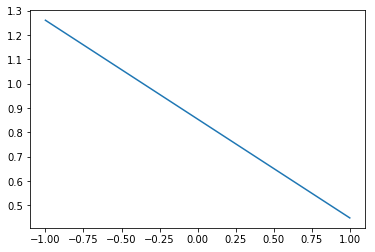

In [48]:
x0 = np.ones([1, 20])
x1 = np.linspace(-1, 1, 20).reshape(1, 20)
x = np.concatenate([x1, x0], axis=0)
w = np.random.multivariate_normal(mean, cov)
y = x.T.dot(w)

plt.plot(x1.reshape(-1), y)

-0.6723772177105743 * x1 + -0.3179980289329158
-1.2358908789899798 * x1 + -0.1823159412125075
-0.21916681965197907 * x1 + 0.6483682535067572
-1.281267277781731 * x1 + 0.7897705749427333
0.7308980170725087 * x1 + -0.29891820731071045
-0.648069721560662 * x1 + -0.2555617939546065
0.5422934799774874 * x1 + 1.1982937126667923
-1.4134943994007307 * x1 + -0.23276105577936823
-0.11650401914796397 * x1 + 0.987435564097739
1.3324548482292757 * x1 + -0.8901236643856204
-0.5937537564582259 * x1 + -1.703691938934132


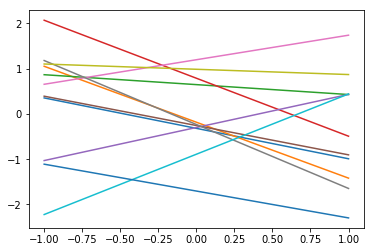

In [49]:
def prior_generator(mean, cov, maxn=10):
    k = 0
    while True:
        if k > maxn:
            break
        k += 1
        yield np.random.multivariate_normal(mean, cov)

def plot_line(w, ax):
    x0 = np.ones([1, 20])
    x1 = np.linspace(-1, 1, 20)
    x = np.concatenate([x1.reshape(1, 20), x0], axis=0)  #2*20
    y = w.dot(x) #w, 1*2
    ax.plot(x1, y)


fig = plt.figure()
ax = plt.axes()
for i in prior_generator(mean, cov):
    print(i[0], "* x1 +", i[1])
    plot_line(i, ax)

In [53]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=mean, cov=cov)

In [66]:
nx, ny = (50, 50)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
xv, yv = np.meshgrid(x, y)
xv.shape, yv.shape

((50, 50), (50, 50))

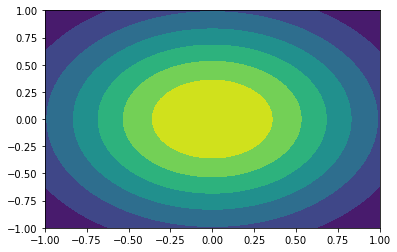

In [68]:
z = np.array([var.pdf([x, y]) for x,y in zip(xv.ravel(),yv.ravel())]).reshape(nx,ny)
plt.contourf(x, y, z)

### create a likelihood function and a data generator

In [103]:
# show the likelihood  as a function of w for each (x, t), we will add log() here
def loglikelihood(w, x, t):
    var = multivariate_normal(mean=w.dot(x), cov=cov_beta)
    return np.log(var.pdf(t))

In [104]:
from numpy.random import uniform

def data_generator(a0, a1, noise=0.2):
    x = np.array([uniform(low=-1, high=1), 1])
    y = np.array([a1, a0]).dot(x.T) + np.random.normal([0], noise)
    yield x, y
    
next(data_generator(0.2, 0.5))

(array([-0.90761828,  1.        ]), array([-0.3004043]))

In [105]:
w = next(prior_generator(mean, cov))
x, y = next(data_generator(0.2, 0.5))
w, x, y

(array([-0.51752469, -1.28357021]),
 array([-0.31550659,  1.        ]),
 array([-0.22362151]))

In [106]:
loglikelihood(w, x, y)

-9.359630322233038

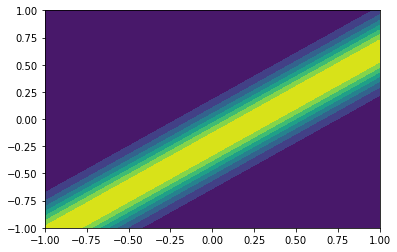

In [196]:
nx, ny = (50, 50)
xline = np.linspace(-1, 1, nx)
yline = np.linspace(-1, 1, ny)
xv, yv = np.meshgrid(xline, yline)
xv.shape, yv.shape

x, y = next(data_generator(0.2, 0.5))
z = np.array([ np.exp(loglikelihood(np.array([w0, w1]), x, y))  for w0,w1 in zip(xv.ravel(),yv.ravel())]).reshape(nx,ny)
plt.contourf(xline, yline, z)


### calculate the posterior for w

In [184]:
class LRBayes(object):
    
    def __init__(self, mean, cov):
        self.X = []
        self.Y = []
        self.dist = lambda w : np.log(multivariate_normal(mean=mean, cov=cov).pdf(w))
        
    
    def update_func(self, a0=0.2, a1=0.5):
        x, y = next(data_generator(a0, a1))
        self.X.append(x)
        self.Y.append(y)
        self.dist = lambda w, func=self.dist : loglikelihood(w, x, y) + func(w)
    
    def plot_contour(self):
        nx, ny = (50, 50)
        xline = np.linspace(-1, 1, nx)
        yline = np.linspace(-1, 1, ny)
        xv, yv = np.meshgrid(xline, yline)
        pairs = [np.array([w1, w0]) for w1,w0 in zip(xv.ravel(),yv.ravel())]
        z = np.array([ np.exp(self.dist(pair)) for pair in pairs ])
        z = z/np.sum(z)  #renomalize to 1
        z2d = z.reshape(nx,ny)
        
        fig = plt.figure(figsize=(15, 5))
        if len(self.X) > 0:
            ax0 = plt.subplot(1,3,1)
            delta_z = np.array([ np.exp(loglikelihood(np.array([w0, w1]), self.X[-1], self.Y[-1] ))  for w0,w1 in zip(xv.ravel(),yv.ravel())]).reshape(nx,ny)
            ax0.contourf(xline, yline, delta_z)
        
        ax = plt.subplot(1,3,2)
        ax.contourf(xline, yline, z2d)
        
        ax2 = plt.subplot(1,3,3)
        for i in range(5):
            w = pairs[np.random.choice(len(pairs), p=z)]
            plot_line(w, ax2)
            if len(self.X) > 0:
                ax2.scatter(np.array(self.X)[:, 0], np.array(self.Y)[:,0] )

In [185]:
lrb = LRBayes(mean, cov)

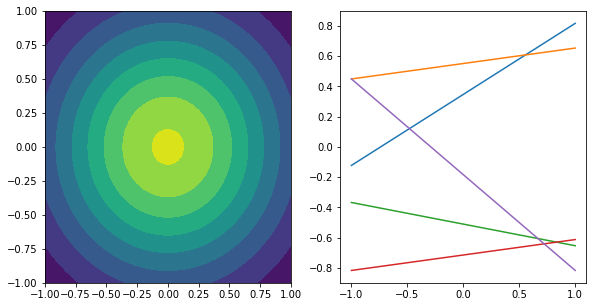

In [186]:
lrb.plot_contour()

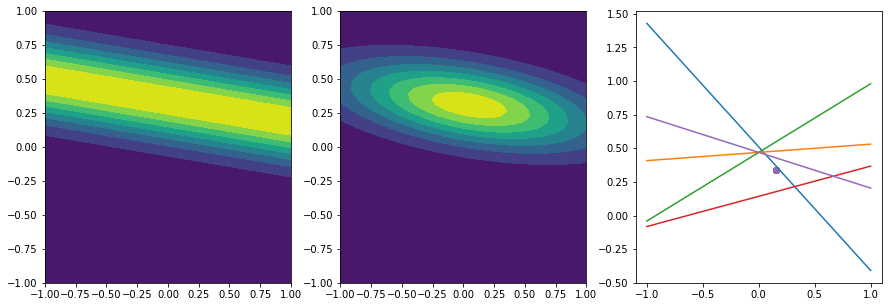

In [187]:
lrb.update_func()
lrb.plot_contour()

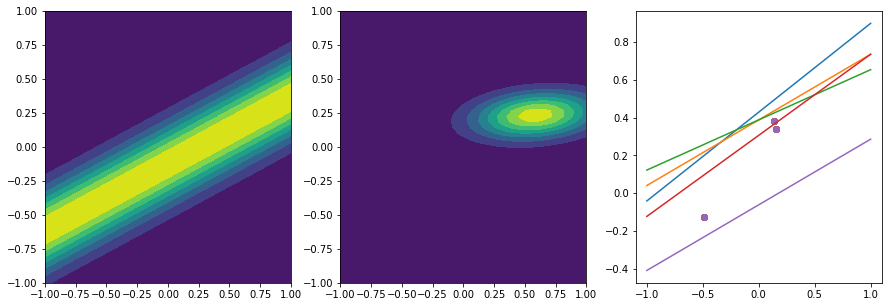

In [189]:
lrb.update_func()
lrb.plot_contour()

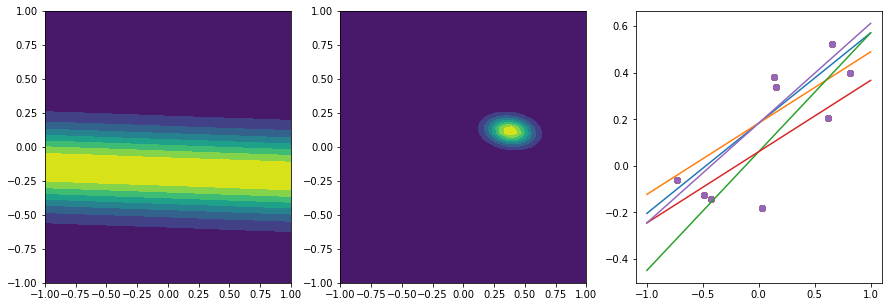

In [195]:
lrb.update_func()
lrb.plot_contour()